## MNIST Digit Conversion from 4 to 9 using CycleGAN

### Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
import imageio
import glob

### Data Loading and Visualization

In [2]:
(train_images,train_labels),(_,_)= tf.keras.datasets.mnist.load_data()

In [4]:
print(f"The shape of dataset is {train_images.shape}")

The shape of dataset is (60000, 28, 28)


In [5]:
BATCH_SIZE=1024

#### Data Visualization

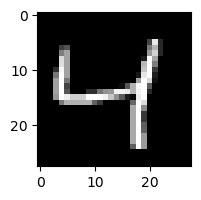

In [9]:
img4 = train_images[train_labels==4]
plt.figure(figsize=(2,2))
plt.imshow(img4[0],cmap="gray")
plt.show()

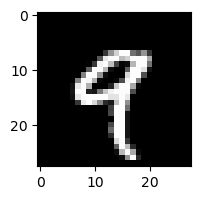

In [10]:
img9 = train_images[train_labels==9]
plt.figure(figsize=(2,2))
plt.imshow(img9[0],cmap="gray")
plt.show()

#### Normalizing both the labels of 4 and 9

In [11]:
img4 = (img4/127.5)-1.0
img9 = (img9/127.5)-1.0

print(f"There are {img9.shape[0]} images of label 9")
print(f"There are {img4.shape[0]} images of label 4")

There are 5949 images of label 9
There are 5842 images of label 4


### Data Preprocessing

#### Resize Images to (32,32)

In [12]:
digit4_data = np.zeros((img4.shape[0],32,32))
for index,img in enumerate(img4):
    digit4_data[index,:,:] = resize(image=img,output_shape=(32,32))
digit4_data.shape

(5842, 32, 32)

In [13]:
digit9_data = np.zeros((img9.shape[0],32,32))
for index,img in enumerate(img9):
    digit9_data[index,:,:] = resize(image=img,output_shape=(32,32))
digit9_data.shape

(5949, 32, 32)

#### Reshape image to (32,32,1) with float pixel values

In [14]:
digit4_data = digit4_data.reshape(digit4_data.shape[0],32,32,1).astype("float32")
digit9_data = digit9_data.reshape(digit9_data.shape[0],32,32,1).astype("float32")

#### Batch and shuffle the data

In [16]:
digit4_data = tf.data.Dataset.from_tensor_slices(digit4_data).shuffle(digit4_data.shape[0],seed=42).batch(BATCH_SIZE)
digit9_data = tf.data.Dataset.from_tensor_slices(digit9_data).shuffle(digit9_data.shape[0],seed=42).batch(BATCH_SIZE)

In [17]:
digit4_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None)>

In [18]:
digit9_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None)>

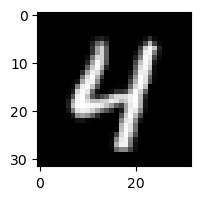

In [19]:
sample_digit4_data  = next(iter(digit4_data))
plt.figure(figsize=(2,2))
plt.imshow(sample_digit4_data[0].numpy(),cmap="gray")
plt.show()

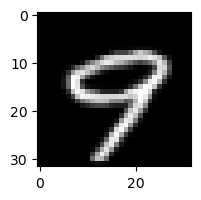

In [20]:
sample_digit9_data  = next(iter(digit9_data))
plt.figure(figsize=(2,2))
plt.imshow(sample_digit9_data[0].numpy(),cmap="gray")
plt.show()

### Model Building

In [21]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Down Sampling

In [32]:
def downsample(filters,size,apply_norm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### Upsampling

In [33]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

### Unets

In [34]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(64, 4, False), # (bs, 16, 16, 64)
        downsample(128, 4), # (bs, 8, 8, 128)
        downsample(128, 4), # (bs, 4, 4, 128)
        downsample(128, 4), # (bs, 2, 2, 128)
        downsample(128, 4) # (bs, 1, 1, 128)
    ]
    up_stack = [
        upsample(128, 4, True), # (bs, 2, 2, 256)
        upsample(128, 4, True), # (bs, 4, 4, 256)
        upsample(128, 4), # (bs, 8, 8, 256)
        upsample(64, 4) # (bs, 16, 16, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[32, 32, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Generator

In [35]:
generator_g = unet_generator()
generator_f = unet_generator()

In [36]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 16, 16, 64)           1024      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 8, 8, 128)            131328    ['sequential_1[0][0]']        
                                                                                                  
 sequential_3 (Sequential)   (None, 4, 4, 128)            262400    ['sequential_2[0][0]']        
                                                                                              

#### Discriminator

In [37]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used 
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[32, 32, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 10, 10, 128)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 256)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [38]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [39]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 sequential_19 (Sequential)  (None, 16, 16, 64)        1024      
                                                                 
 sequential_20 (Sequential)  (None, 8, 8, 128)         131328    
                                                                 
 zero_padding2d (ZeroPaddin  (None, 10, 10, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 7, 256)         524288    
                                                                 
 instance_normalization_17   (None, 7, 7, 256)         512       
 (InstanceNormalization)                                   

### Model Training

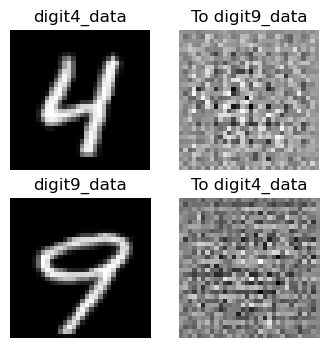

In [40]:
to_digit9_data = generator_g(sample_digit4_data)
to_digit4_data = generator_f(sample_digit9_data)
plt.figure(figsize=(4, 4))

imgs = [sample_digit4_data, to_digit9_data, sample_digit9_data, to_digit4_data]
title = ['digit4_data', 'To digit9_data', 'digit9_data', 'To digit4_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

#### Declare Loss as Binary Cross Entropy

In [43]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [44]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

In [45]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [46]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

In [47]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

#### Optimizer

In [48]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [49]:
EPOCHS = 100

### Checkpoint Initialization

In [50]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [51]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Training Flow

In [52]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

#### Train the CycleGAN for several Epochs

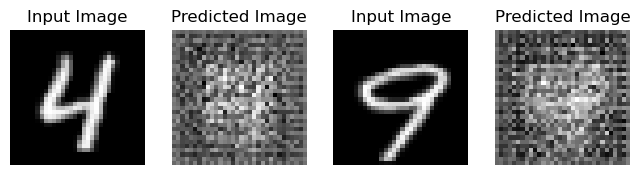

Saving checkpoint for epoch 1 at ./Trained_Model\ckpt-1


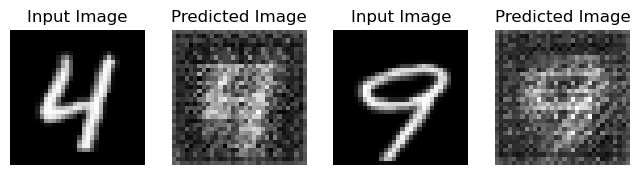

Saving checkpoint for epoch 2 at ./Trained_Model\ckpt-2


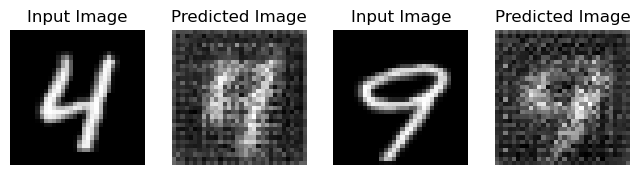

Saving checkpoint for epoch 3 at ./Trained_Model\ckpt-3


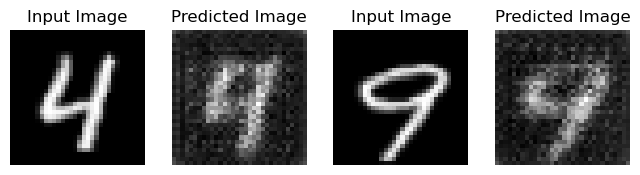

Saving checkpoint for epoch 4 at ./Trained_Model\ckpt-4


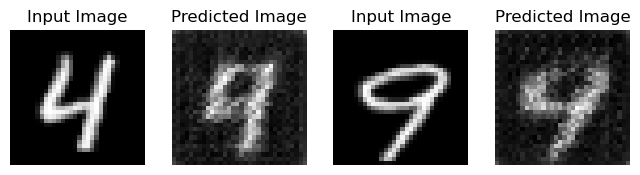

Saving checkpoint for epoch 5 at ./Trained_Model\ckpt-5


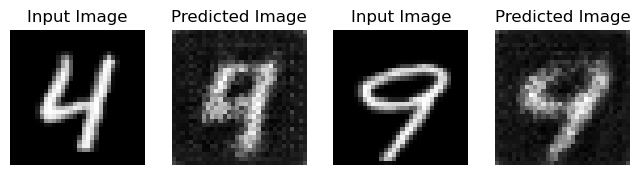

Saving checkpoint for epoch 6 at ./Trained_Model\ckpt-6


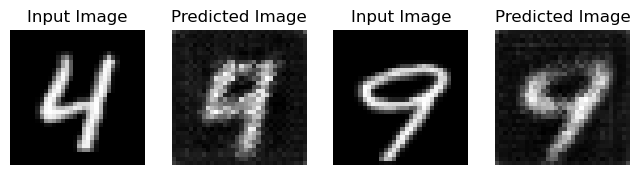

Saving checkpoint for epoch 7 at ./Trained_Model\ckpt-7


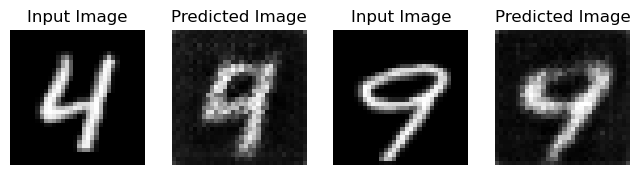

Saving checkpoint for epoch 8 at ./Trained_Model\ckpt-8


In [ ]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((digit4_data, digit9_data)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_digit4_data, generator_f, sample_digit9_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

#### Generate a GIF for visualization of Results

In [ ]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
pip install git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)